# Table of content

## [Introduction](#1)

## Part I: [Data examine](#2)

* Examining data size, unique values

## Part II: [Data clean](#3)

* Merge dataset
* Convert numerical and dummy columns
* Create new df by groupby people
* Calculate counts of each event
* Calculate viewed and completed rate

## Part III: [Data explore](#4)

* Inspect customer features
* Inspect data structure by divided viewed and completed rate
* Examine relation between features and offers

## Part IV: [Conclusion](#5)

* Customer features between genders, ages and incomes
* Relation between ages and income in different viewed and completed rate
* Summary of customer features
* Relation between offers
* Offer preferences

<a class="anchor" id="1"></a>
# Starbucks Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Load data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
port = portfolio.copy()
prof = profile.copy()
trans = transcript.copy()

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [7]:
transcript.query("event == 'transaction'").head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


<a class="anchor" id="2"></a>
# Part I: Data examine

`Task`: Examining each datasets size, unique values.

## Portfolio

In [8]:
bogo = port.groupby('offer_type').size()[0]
discount = port.groupby('offer_type').size()[1]
info = port.groupby('offer_type').size()[2]
re_bogo = port[port['offer_type']=='bogo'].groupby('reward').size().index
re_dis = port[port['offer_type']=='discount'].groupby('reward').size().index
re_info = port[port['offer_type']=='informational'].groupby('reward').size().index

In [9]:
print('Below are the number of different offers:', '\n')
print(f'Bogo has {bogo} offers, which the rewards have {re_bogo[0]} and {re_bogo[1]}.')
print(f'Discount has {discount} offers, which the rewards have {re_dis[0]}, {re_dis[1]} and {re_dis[2]}.')
print(f'Informational has {info} offers, which the rewards only have {re_bogo[0]}.')

Below are the number of different offers: 

Bogo has 4 offers, which the rewards have 5 and 10.
Discount has 4 offers, which the rewards have 2, 3 and 5.
Informational has 2 offers, which the rewards only have 5.


## Profile

In [10]:
total_id = prof.id.nunique()
genders = [i for i in prof.gender.unique()]
female = prof[prof['gender']==genders[1]]['id'].nunique()
male = prof[prof['gender']==genders[2]]['id'].nunique()
others = prof[prof['gender']==genders[3]]['id'].nunique()
non = prof[~prof['gender'].isin(['F', 'M', 'O'])]['id'].nunique()

In [11]:
print(f'The numbers of total unique customers is {total_id}.')
print(f'There are {len(genders)} genders in dataset which are {genders[0]}, {genders[1]}, {genders[2]} and {genders[3]}.')
print(f'In this profile dataset, there are {female} people identified as Female, {male} as Male, {others} as Others and \n{non} identified as None.')

The numbers of total unique customers is 17000.
There are 4 genders in dataset which are None, F, M and O.
In this profile dataset, there are 6129 people identified as Female, 8484 as Male, 212 as Others and 
2175 identified as None.


## Transcript

### Cleaning transcript dataset before examine

In [12]:
# size of transcript
trans.shape

(306534, 4)

In [13]:
# convert dict keys and values into str
offer_ids = []
id_values = []

for i in range(trans.shape[0]):
    offer_ids.append([*trans['value'][i].keys()][0])
    id_values.append([*trans['value'][i].values()][0])

In [14]:
# find out how many different ids
np.unique(offer_ids)

array(['amount', 'offer id', 'offer_id'], dtype='<U8')

In [15]:
# create new columns use different ids and values
trans['offer_id'] = offer_ids
trans['id_value'] = id_values

# transfer id into same name, because its value is same as portfolio's id
trans['offer_id'] = trans['offer_id'].apply(lambda x: 'offer id' if x == 'offer_id' else x)
trans = trans.drop('value', axis=1)
trans.head()

,person,event,time,offer_id,id_value
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [16]:
# check cleaning is correct
assert [*transcript.value[0].keys()][0] == trans.offer_id[0]
assert [*transcript.value[10].values()][0] == trans.id_value[10]
assert [*transcript.value[12005].items()][0] == (trans.offer_id[12005], trans.id_value[12005])
print('Transfering correct!!')

Transfering correct!!


In [17]:
offers = trans.groupby('offer_id').size().index
events = trans.groupby('event').size()
print(f'In transcript dataset, there are {trans.person.nunique()} unique customers.')
print(f'There {len(offers)} different offer ids, which are {offers[0]} and {offers[1]}.')
print(f'Those offers can be divided into {len(events)} events.\n')
print('Here are the number of events')
print(f'{events.index[0]}: {events.values[0]}')
print(f'{events.index[1]}: {events.values[1]}')
print(f'{events.index[2]}: {events.values[2]}')
print(f'{events.index[3]}: {events.values[3]}')

In transcript dataset, there are 17000 unique customers.
There 2 different offer ids, which are amount and offer id.
Those offers can be divided into 4 events.

Here are the number of events
offer completed: 33579
offer received: 76277
offer viewed: 57725
transaction: 138953


In [18]:
# check whether existed different offer ids
off_ids = trans[trans['offer_id']!='amount']['id_value'].unique()
print('How many unique customers of transcript are different from portfolio:', len(np.setdiff1d(off_ids, port['id'].unique())))

# portion of not offer event
transactions = trans[trans['event']=='transaction'].shape[0]
print(f'What is the percentage of observations which paid without using offers: {round(transactions / trans.shape[0]*100, 2)}%')

How many unique customers of transcript are different from portfolio: 0
What is the percentage of observations which paid without using offers: 45.33%


<a class="anchor" id="3"></a>
# Part II: Data cleaning

`Task`: 

`1.` Merging each dataset by key columns.

`2.` Converting numerical column values into bins, like age and income.

`3.` Dividing merged df by events and converting offers into int values.

`4.` Creating a new df by grouping person, so it would not have duplicated customer ids.

`5.` Finding out which offers had received, viewed and completed and which were not.

`6.` Calculting viewed rate, completed rates.

### Merge portfolio, profile and transcript

In [19]:
# merge different df by same id column
merge_offer = trans.merge(port, how='outer', left_on = 'id_value', right_on = 'id')
merge_offer = merge_offer.drop(['id'], axis=1)
merge_offer.head()

,person,event,time,offer_id,id_value,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo


In [20]:
ful_comb = merge_offer.merge(prof,how='outer', left_on='person', right_on='id')
ful_comb = ful_comb.drop('id', axis=1)
ful_comb['became_member_on'] = ful_comb['became_member_on'].astype('str')
ful_comb['became_member_on'] = pd.to_datetime(ful_comb['became_member_on'])

# alter NaN into 0
income_lamb = lambda x: x if x > 0 else 0
ful_comb['income'] = ful_comb['income'].apply(income_lamb)

ful_comb.head()

,person,event,time,offer_id,id_value,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,504,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,offer completed,510,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,F,75,2017-05-09,100000.0


In [21]:
# reorder columns
new_col = ['person', 'gender', 'age', 'income', 'became_member_on', 
       'event', 'time', 'offer_type', 'offer_id', 'id_value', 
       'reward', 'difficulty', 'duration', 'channels']

ful_comb =ful_comb.reindex(columns=new_col)
ful_comb.head()

,person,gender,age,income,became_member_on,event,time,offer_type,offer_id,id_value,reward,difficulty,duration,channels
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,0,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer viewed,6,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
2,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,132,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,504,bogo,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]"
4,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,510,bogo,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]"


In [22]:
ful = ful_comb.copy()
ful.head()

,person,gender,age,income,became_member_on,event,time,offer_type,offer_id,id_value,reward,difficulty,duration,channels
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,0,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer viewed,6,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
2,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,132,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,504,bogo,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]"
4,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,510,bogo,offer id,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]"


### Select offer only observations

In [23]:
NaN = np.nan

In [24]:
# select observations which is not paid without offers
ful_offer = ful[ful['event']!='transaction']
ful_no_offer = ful[ful['event']=='transaction']
ful_offer.shape, ful_no_offer.shape

((167581, 14), (138953, 14))

In [25]:
new_ful = ful_offer.copy()
new_ful.head(2)

,person,gender,age,income,became_member_on,event,time,offer_type,offer_id,id_value,reward,difficulty,duration,channels
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,0,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer viewed,6,bogo,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]"


### Convert dummy and date columns

In [26]:
new_ful['gender'] = new_ful.gender.fillna("None")
new_ful['year'] = new_ful['became_member_on'].dt.year
new_ful['month'] = new_ful['became_member_on'].dt.month
new_ful['date'] = new_ful['became_member_on'].dt.day
new_ful = new_ful.sort_index()
new_ful = new_ful.drop('offer_id', axis=1)
new_ful = new_ful.reset_index(drop=True)
new_ful.head()

,person,gender,age,income,became_member_on,event,time,offer_type,id_value,reward,difficulty,duration,channels,year,month,date
0,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]",2017,5,9
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer viewed,6,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]",2017,5,9
2,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,132,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,"[web, email, mobile]",2017,5,9
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer received,504,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]",2017,5,9
4,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,2017-05-09,offer completed,510,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,"[web, email, mobile, social]",2017,5,9


### Convert numerical columns into bins

In [27]:
def value_ranges(df, col, new_col, value_list=None):
    '''
    INPUT:
    
    df - dataframe
    col - (str), exist column in df 
    new_col - (str), new empty ranges column in df
    value_list - (list), value of ranges
    
    OUTPUT:
    
    None - convert specfic column value into range value
    '''
    if len(value_list) == 5:
        for idx in range(len(df[col])):
            if df[col][idx] <= value_list[0]:
                df[new_col][idx] = 1
            elif df[col][idx] > value_list[0] and df[col][idx] <= value_list[1]:
                df[new_col][idx] = 2
            elif df[col][idx] > value_list[1] and df[col][idx] <= value_list[2]:
                df[new_col][idx] = 3
            elif df[col][idx] > value_list[2] and df[col][idx] <= value_list[3]:
                df[new_col][idx] = 4
            elif df[col][idx] > value_list[3] and df[col][idx] <= value_list[4]:
                df[new_col][idx] = 5
            else:
                df[new_col][idx] = 6
                
    else:
        for idx in range(len(df[col])):
            if df[col][idx] <= value_list[0]:
                df[new_col][idx] = 1
            elif df[col][idx] > value_list[0] and df[col][idx] <= value_list[1]:
                df[new_col][idx] = 2
            elif df[col][idx] > value_list[1] and df[col][idx] <= value_list[2]:
                df[new_col][idx] = 3
            else:
                df[new_col][idx] = 4

In [28]:
# create new range columns
new_ful['age_range'] = NaN
new_ful['income_range'] = NaN

age_list = [35, 50, 65, 80, 95]
income_list = [20000, 40000, 60000, 80000, 100000]

# insert ranges into new columns
value_ranges(new_ful, 'age', 'age_range', value_list=age_list)
value_ranges(new_ful, 'income', 'income_range', value_list=income_list)

<ipython-input-27-a51295991034>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 4
<ipython-input-27-a51295991034>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 3
<ipython-input-27-a51295991034>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 2
<ipython-input-27-a51295991034>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [29]:
new_ful[['age', 'age_range', 'income', 'income_range']].head(20)

,age,age_range,income,income_range
0,75,4.0,100000.0,5.0
1,75,4.0,100000.0,5.0
2,75,4.0,100000.0,5.0
3,75,4.0,100000.0,5.0
4,75,4.0,100000.0,5.0
5,75,4.0,100000.0,5.0
6,75,4.0,100000.0,5.0
7,75,4.0,100000.0,5.0
8,75,4.0,100000.0,5.0
9,75,4.0,100000.0,5.0


### Convert offer id values

In [30]:
id_dic = {}
for i, ids in enumerate(port['id']):
    id_dic[ids] = i+1
    
id_dic

{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

In [31]:
new_ful['ids'] = new_ful['id_value'].map(id_dic)           
new_ful[['id_value', 'ids']].head(10)

,id_value,ids
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
3,f19421c1d4aa40978ebb69ca19b0e20d,9
4,f19421c1d4aa40978ebb69ca19b0e20d,9
5,f19421c1d4aa40978ebb69ca19b0e20d,9
6,ae264e3637204a6fb9bb56bc8210ddfd,1
7,ae264e3637204a6fb9bb56bc8210ddfd,1
8,ae264e3637204a6fb9bb56bc8210ddfd,1
9,5a8bc65990b245e5a138643cd4eb9837,8


In [32]:
assert list(new_ful[new_ful.ids == 4]['id_value'])[0] == list(id_dic.keys())[3]
assert list(new_ful[new_ful.ids == 9]['id_value'])[0] == list(id_dic.keys())[8]
assert list(new_ful[new_ful.ids == 1]['id_value'])[0] == list(id_dic.keys())[0]
assert list(new_ful[new_ful.ids == 10]['id_value'])[0] == list(id_dic.keys())[9]
print("That's right!!")

That's right!!


### Divide subsets by events - received, viewed and completed

In [33]:
# make a check point
offer_df = new_ful.copy()

received = offer_df[offer_df['event']=='offer received']
viewed = offer_df[offer_df['event']=='offer viewed']
completed = offer_df[offer_df['event']=='offer completed']

In [34]:
# find out how many customers in different events
re = received.groupby(['person']).size()
view = viewed.groupby(['person']).size()
comp = completed.groupby(['person']).size()

In [35]:
print(f'In received subset, there are total {received.person.nunique()} customers, the average offers received are {round(re.mean(), 1)} times.')
print(f'In viewed subset, there are total {viewed.person.nunique()} customers, the average offers viewed are {round(view.mean(), 1)} times.')
print(f'In completed subset, there are total {completed.person.nunique()} customers, the average offers completed are {round(comp.mean(), 1)} times.')
print(f'According to above, there are {round(viewed.person.nunique()/received.person.nunique()*100,2)}% of people had viewed their offers at least once, and only {round(completed.person.nunique()/received.person.nunique()*100,2)}% were completed it at least once.')

In received subset, there are total 16994 customers, the average offers received are 4.5 times.
In viewed subset, there are total 16834 customers, the average offers viewed are 3.4 times.
In completed subset, there are total 12774 customers, the average offers completed are 2.6 times.
According to above, there are 99.06% of people had viewed their offers at least once, and only 75.17% were completed it at least once.


### Group by each subset by unique customers with their profile features with others columns

In [36]:
def group_features(df, cols, rename_col=True):
    '''
    INPUT:
    df- dataset 
    cols- (str) single column name or list of column names
    rename_col- bool, rename column name 
    
    OUTPUT:
    sub- unstack dataset with fill 0 for NaN values and reset index
    '''
    sub = pd.DataFrame(df.groupby(cols).size().unstack(fill_value=0))
    new_cols = [f"{cols[1]}_{col}" for col in sub.columns]
    
    if rename_col:
        sub.columns = new_cols
        sub = sub.reset_index()
        
    else:
        sub = sub.reset_index()
        
    return sub

def merge_features(df, on='person'):
    '''
    INPUT:
    df - dataframe
    on - (str) merge subsets on specific column name
    
    OUTPUT:
    new_df - a new merge dataframe 
    '''
    df1 = group_features(df, ['person', 'gender', 'age_range', 'income_range', 'event'], rename_col=False).iloc[:, :4]
    df2 = group_features(df, ['person', 'ids'])
    new_df = df1.merge(df2, on=on, how='outer')
    new_df = new_df.set_index('person')
    
    return new_df

In [37]:
# use customer ids as index in different events
re_group = merge_features(received)
view_group = merge_features(viewed)
comp_group = merge_features(completed)

In [38]:
# insert new empty columns
comp_group.insert(5, 'ids_3', NaN)

In [39]:
comp_group.insert(10, 'ids_8', NaN)
comp_group = comp_group.fillna(0)
comp_group.head()

,gender,age_range,income_range,ids_1,ids_2,ids_3,ids_4,ids_5,ids_6,ids_7,ids_8,ids_9,ids_10
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,1.0,4.0,0,0,0.0,0,0,0,1,0.0,1,1
0011e0d4e6b944f998e987f904e8c1e5,O,2.0,3.0,0,0,0.0,1,1,1,0,0.0,0,0
0020c2b971eb4e9188eac86d93036a77,F,3.0,5.0,0,1,0.0,0,0,0,2,0.0,0,0
0020ccbbb6d84e358d3414a3ff76cffd,F,1.0,3.0,0,0,0.0,1,0,1,0,0.0,1,0
003d66b6608740288d6cc97a6903f4f0,F,1.0,4.0,0,0,0.0,0,1,0,2,0.0,0,0


In [40]:
e = ['re', 'view', 'comp']
re, view, comp = {}, {}, {}
for i in range(1, 11):
    re[f'ids_{i}'] = e[0] + f'_{i}'
    view[f'ids_{i}'] = e[1] + f'_{i}'
    comp[f'ids_{i}'] = e[2] + f'_{i}'

In [41]:
re_group = re_group.rename(columns=re)
view_group = view_group.rename(columns=view)
comp_group = comp_group.rename(columns=comp)

In [42]:
merge_ids = re_group.merge(view_group.iloc[:, 3:], left_on=re_group.index, right_on=view_group.index, how='outer').set_index('key_0')
merge_ids = merge_ids.merge(comp_group.iloc[:, 3:], left_on=merge_ids.index, right_on=comp_group.index, how='outer').set_index('key_0').fillna(0)
merge_ids.head(2)

,gender,age_range,income_range,re_1,re_2,re_3,re_4,re_5,re_6,re_7,...,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
key_0,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,1.0,4.0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,None,6.0,1.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# convert double or multiple counts into 1 only
s_ids = merge_ids.iloc[:, 3:33].mask(merge_ids.iloc[:, 3:33] > 1, 1)
merge_ids = pd.concat([merge_ids.iloc[:, :3], s_ids], axis=1)
merge_ids.head()

,gender,age_range,income_range,re_1,re_2,re_3,re_4,re_5,re_6,re_7,...,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
key_0,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,1.0,4.0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
00116118485d4dfda04fdbaba9a87b5c,None,6.0,1.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,O,2.0,3.0,0,0,1,1,1,1,0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,F,3.0,5.0,1,1,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,F,1.0,3.0,0,0,0,1,0,1,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [44]:
merge_ids['received'] = merge_ids[re.values()].sum(axis=1)
merge_ids['viewed'] = merge_ids[view.values()].sum(axis=1)
merge_ids['completed'] = merge_ids[comp.values()].sum(axis=1)
merge_ids['VR'] = round(merge_ids['viewed'] / merge_ids['received'], 2)
merge_ids['CR'] = round(merge_ids['completed'] / merge_ids['received'], 2)
merge_ids.head(2)

,gender,age_range,income_range,re_1,re_2,re_3,re_4,re_5,re_6,re_7,...,comp_6,comp_7,comp_8,comp_9,comp_10,received,viewed,completed,VR,CR
key_0,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,1.0,4.0,0,0,1,0,0,0,1,...,0.0,1.0,0.0,1.0,1.0,5,4.0,3.0,0.8,0.6
00116118485d4dfda04fdbaba9a87b5c,None,6.0,1.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,1.0,0.0


In [45]:
# convert viewed and completed rate into bins
merge_ids['VR_range'] = NaN
merge_ids['CR_range'] = NaN

rates = ['VR', 'CR']
ranges = ['VR_range', 'CR_range']
range_values = [0.25, 0.5, 0.75]

for i, rate in enumerate(rates):
    value_ranges(merge_ids, rates[i], ranges[i], value_list=range_values)

<ipython-input-27-a51295991034>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 4
<ipython-input-27-a51295991034>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 3
<ipython-input-27-a51295991034>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col][idx] = 2
<ipython-input-27-a51295991034>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

In [46]:
merge_ids.head(20)

,gender,age_range,income_range,re_1,re_2,re_3,re_4,re_5,re_6,re_7,...,comp_8,comp_9,comp_10,received,viewed,completed,VR,CR,VR_range,CR_range
key_0,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,M,1.0,4.0,0,0,1,0,0,0,1,...,0.0,1.0,1.0,5,4.0,3.0,0.80,0.60,4.0,3.0
00116118485d4dfda04fdbaba9a87b5c,None,6.0,1.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1,1.0,0.0,1.00,0.00,4.0,1.0
0011e0d4e6b944f998e987f904e8c1e5,O,2.0,3.0,0,0,1,1,1,1,0,...,0.0,0.0,0.0,5,5.0,3.0,1.00,0.60,4.0,3.0
0020c2b971eb4e9188eac86d93036a77,F,3.0,5.0,1,1,0,0,0,0,1,...,0.0,0.0,0.0,4,3.0,2.0,0.75,0.50,3.0,2.0
0020ccbbb6d84e358d3414a3ff76cffd,F,1.0,3.0,0,0,0,1,0,1,0,...,0.0,1.0,0.0,4,4.0,3.0,1.00,0.75,4.0,3.0
003d66b6608740288d6cc97a6903f4f0,F,1.0,4.0,0,0,1,0,1,0,1,...,0.0,0.0,0.0,4,3.0,2.0,0.75,0.50,3.0,2.0
00426fe3ffde4c6b9cb9ad6d077a13ea,F,1.0,4.0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,4,2.0,1.0,0.50,0.25,2.0,1.0
004b041fbfe44859945daa2c7f79ee64,F,3.0,4.0,0,0,1,0,0,0,1,...,0.0,1.0,0.0,3,2.0,2.0,0.67,0.67,3.0,3.0
004c5799adbf42868b9cff0396190900,M,3.0,5.0,1,0,0,0,0,0,1,...,0.0,1.0,0.0,3,2.0,3.0,0.67,1.00,3.0,4.0


In [47]:
def summary(df, cols):
    new_df = pd.DataFrame()
    for i, col in enumerate(cols):
        new_df[e[i]] = df[col.values()].sum().reset_index(drop=True)
    
    new_df = new_df.rename(lambda x: x+1, axis='index')
        
    return new_df

#### Merge offer ids

In [48]:
def ids_list(df, person):
    '''
    INPUT:
    
    df- dataframe
    person- (str), customer id
    
    OUTPUT:
    
    ids- list of offered ids
    '''
    ids = []
    for i, value in enumerate(df.loc[person].values[3:]):
        ids.append(np.repeat(i + 1, value))
            
    return np.concatenate(ids).tolist()

def person_ids_dic(df):
    '''
    INPUT:
    
    df- dataframe
    
    OUTPUT:
    
    person_ids - (dic), customer id as key, offered ids as values
    '''
    person_ids = {}
    for person in df.index:
        person_ids[person] = ids_list(df, person)
        
    return person_ids

def offer_sum(df, new_feature):
    '''
    INPUT: 
    
    df- dataframe
    new_feature- (str), a name for new column
    
    OUTPUT:
    
    new_df- dataframe with new column which contain viewed or completed ids
    '''
    new_df = df.iloc[:, 3:]
    new_df[new_feature] = person_ids_dic(df).values()
    
    return new_df

In [49]:
# find out and return ids by different events
received_sum = offer_sum(re_group, 'received_ids')
viewed_sum = offer_sum(view_group, 'viewed_ids')
comp_sum = offer_sum(comp_group, 'completed_ids')

In [50]:
received_sum.head()

,re_1,re_2,re_3,re_4,re_5,re_6,re_7,re_8,re_9,re_10,received_ids
person,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,1,0,0,0,1,1,1,1,"[3, 7, 8, 9, 10]"
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,0,0,2,0,"[9, 9]"
0011e0d4e6b944f998e987f904e8c1e5,0,0,1,1,1,1,0,1,0,0,"[3, 4, 5, 6, 8]"
0020c2b971eb4e9188eac86d93036a77,1,1,0,0,0,0,2,1,0,0,"[1, 2, 7, 7, 8]"
0020ccbbb6d84e358d3414a3ff76cffd,0,0,0,1,0,1,0,1,1,0,"[4, 6, 8, 9]"


In [51]:
def double_ids(id_list):
    '''
    INPUT:
    
    id_list - list of offer ids
    
    OUTPUT:
    
    ids- list of doubled offered ids
    '''
    ids = []
    if id_list != 0:
        for i, value in enumerate(id_list):
            if id_list.count(value) > 1:
                ids.append(value)
    return ids

def double_feature(df, col, dic):
    '''
    INPUT:
    
    df - dataframe
    col - (str), column name
    dic - (dict), person as keys, list of ids as values
    
    OUTPUT: 
    
    return list of ids by different person as new column values
    '''
    df[col] = dic.values()

In [52]:
# merge subsets
offer_sum = pd.concat([received_sum['received_ids'], viewed_sum['viewed_ids'], comp_sum['completed_ids']], axis=1).fillna(0)
offer_sum.head()

,received_ids,viewed_ids,completed_ids
person,,,
0009655768c64bdeb2e877511632db8f,"[3, 7, 8, 9, 10]","[3, 7, 8, 9]","[7, 9, 10]"
00116118485d4dfda04fdbaba9a87b5c,"[9, 9]","[9, 9]",0
0011e0d4e6b944f998e987f904e8c1e5,"[3, 4, 5, 6, 8]","[3, 4, 5, 6, 8]","[4, 5, 6]"
0020c2b971eb4e9188eac86d93036a77,"[1, 2, 7, 7, 8]","[2, 7, 8]","[2, 7, 7]"
0020ccbbb6d84e358d3414a3ff76cffd,"[4, 6, 8, 9]","[4, 6, 8, 9]","[4, 6, 9]"


In [53]:
# create dicts by events
event_cols = ['received_ids', 'viewed_ids', 'completed_ids']
re_double = {}
view_double = {}
comp_double = {}
for x in range(len(offer_sum)):
    re_double[offer_sum.index[x]] = double_ids(offer_sum[event_cols[0]][x])
    view_double[offer_sum.index[x]] = double_ids(offer_sum[event_cols[1]][x])
    comp_double[offer_sum.index[x]] = double_ids(offer_sum[event_cols[2]][x])

In [54]:
# find out double or multiple ids by events
double_dic = [re_double, view_double, comp_double]
for i, new_col in enumerate(['re_double', 'view_double', 'comp_double']):
    double_feature(offer_sum, new_col, double_dic[i])
    
offer_sum.head()

,received_ids,viewed_ids,completed_ids,re_double,view_double,comp_double
person,,,,,,
0009655768c64bdeb2e877511632db8f,"[3, 7, 8, 9, 10]","[3, 7, 8, 9]","[7, 9, 10]",[],[],[]
00116118485d4dfda04fdbaba9a87b5c,"[9, 9]","[9, 9]",0,"[9, 9]","[9, 9]",[]
0011e0d4e6b944f998e987f904e8c1e5,"[3, 4, 5, 6, 8]","[3, 4, 5, 6, 8]","[4, 5, 6]",[],[],[]
0020c2b971eb4e9188eac86d93036a77,"[1, 2, 7, 7, 8]","[2, 7, 8]","[2, 7, 7]","[7, 7]",[],"[7, 7]"
0020ccbbb6d84e358d3414a3ff76cffd,"[4, 6, 8, 9]","[4, 6, 8, 9]","[4, 6, 9]",[],[],[]


In [55]:
def intersect_id_list(ids1, ids2, intersect=True):
    '''
    INPUT:
    
    ids1 - list of ids
    ids2 - list of ids
    intersect - (bool), True or False
    
    OUTPUT:
    
    ids2_from_ids1 - if intersect is True return same ids which show in ids1 and 2, if False return 
                     ids which only in ids2 not in ids1
    '''
    ids2_from_ids1 = []
    if intersect:
        if ids1 != 0:
            if ids2 != 0:
                for i in ids2:
                    if i in ids1:
                        ids2_from_ids1.append(i)
            else:
                ids2_from_ids1 = []
        else:
            ids2_from_ids1 = []
    else:
        if ids1 != 0:
            if ids2 != 0:
                for i in ids2:
                    if i not in ids1:
                        ids2_from_ids1.append(i)
            else:
                ids2_from_ids1 = []
        else:
            ids2_from_ids1 = []
            
    return ids2_from_ids1

def intersect_dic(df, col1, col2, intersect=True):
    '''
    INPUT:
    
    df - dataframe
    col1 - (str), column name
    col2 - (str), column name
    intersect - (bool), True or False
    
    OUTPUT:
    
    inter_dic - (dict), unique customer id as keys, if intersect is True return same ids which show 
                        in ids1 and 2 as values, if False return ids which only in ids2 not in ids1 
    '''
    inter_dic = {}
    for i, (x, y) in enumerate(zip(df[col1], df[col2])):
        inter_dic[df.index[i]] = intersect_id_list(x, y, intersect)

    return inter_dic

In [56]:
# find out intersect ids and different ids from viewed and completed events
offer_sum['comp_from_viewed'] = intersect_dic(offer_sum, 'viewed_ids', 'completed_ids').values()
offer_sum['comp_never_viewed'] = intersect_dic(offer_sum, 'viewed_ids', 'completed_ids', intersect=False).values()
offer_sum.head()

,received_ids,viewed_ids,completed_ids,re_double,view_double,comp_double,comp_from_viewed,comp_never_viewed
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,"[3, 7, 8, 9, 10]","[3, 7, 8, 9]","[7, 9, 10]",[],[],[],"[7, 9]",[10]
00116118485d4dfda04fdbaba9a87b5c,"[9, 9]","[9, 9]",0,"[9, 9]","[9, 9]",[],[],[]
0011e0d4e6b944f998e987f904e8c1e5,"[3, 4, 5, 6, 8]","[3, 4, 5, 6, 8]","[4, 5, 6]",[],[],[],"[4, 5, 6]",[]
0020c2b971eb4e9188eac86d93036a77,"[1, 2, 7, 7, 8]","[2, 7, 8]","[2, 7, 7]","[7, 7]",[],"[7, 7]","[2, 7, 7]",[]
0020ccbbb6d84e358d3414a3ff76cffd,"[4, 6, 8, 9]","[4, 6, 8, 9]","[4, 6, 9]",[],[],[],"[4, 6, 9]",[]


In [57]:
assert offer_sum['comp_from_viewed'][0] == [i for i in offer_sum['completed_ids'][0] if i in offer_sum['viewed_ids'][0]]
assert offer_sum['comp_from_viewed'][10] == [i for i in offer_sum['completed_ids'][10] if i in offer_sum['viewed_ids'][10]]
assert offer_sum['comp_never_viewed'][20] == [i for i in offer_sum['completed_ids'][20] if i not in offer_sum['viewed_ids'][20]]
assert offer_sum['comp_never_viewed'][150] == [i for i in offer_sum['completed_ids'][150] if i not in offer_sum['viewed_ids'][150]]
print("That's correct!!")

That's correct!!


In [58]:
# merge as new df
new_df = pd.concat([merge_ids, offer_sum.iloc[:, 3:]], axis=1)

In [59]:
new_df.shape

(16994, 45)

<a class="anchor" id="4"></a>
# Part III: Data explore

`Task`:

`1.` Inspecting entire customer feature, like ages, genders and incomes.

`2.` Dividing dataset into subset by different viewed rates and examining customer structures.

`3.` Analyzing completed rates and offer ids in different subsets.

`4.` Examining offer features.

`5.` Examining relation between subsets.

### Examine overall customer profiles 

In [60]:
def feature_plots(df, col, title):
    '''
    INPUT:
    
    df - dataframe
    col - (str), column name
    title - (str), title name of figure
    
    OUTPUT:
    
    return pie plot of percentage of column's values
    '''
    plt.figure(figsize=(6,6))
    plt.pie(round(df.groupby(col).size() / df.groupby(col).size().sum(), 2), autopct='%.2f%%',
           labels=df.groupby(col).size().index)
    plt.title(f'Percentage of {title}')
    plt.xlabel(f'{title}')

#### Genders

gender
F       6125
M       8483
None    2174
O        212
dtype: int64


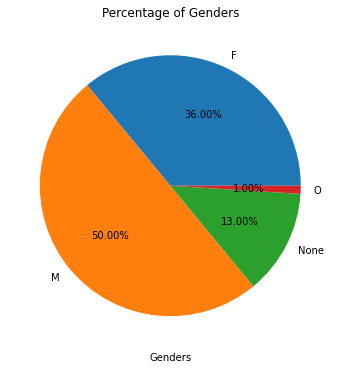

In [61]:
# show counts of each genders and pie plot of percentages
print(new_df.groupby('gender').size())
feature_plots(new_df, 'gender', 'Genders')

There are **50%** of customers are `Male`, 36% are Female and others.

#### Ages

age_range
1.0    2374
2.0    3319
3.0    5144
4.0    2998
5.0     937
6.0    2222
dtype: int64 

Range 1: below 35 yr
Range 2: between 36 to 50 yr
Range 3: between 51 to 65 yr
Range 4: between 66 to 80 yr
Range 5: between 81 to 95 yr
Range 6: above 96 yr


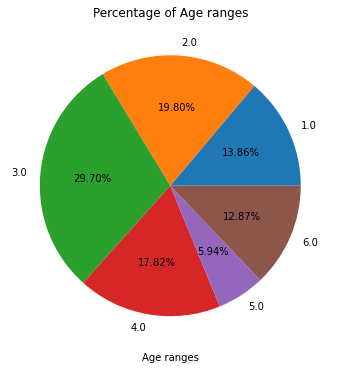

In [62]:
# show age bins and pie plot percentage
print(new_df.groupby('age_range').size(), '\n')
print('Range 1: below 35 yr')
print('Range 2: between 36 to 50 yr')
print('Range 3: between 51 to 65 yr')
print('Range 4: between 66 to 80 yr')
print('Range 5: between 81 to 95 yr')
print('Range 6: above 96 yr')
feature_plots(new_df, 'age_range', 'Age ranges')

Among age ranges, `2, 3 and 4` have higher percentage, **3 is the highest which is around 30%**. 

#### Incomes

income_range
1.0    2174
2.0    2133
3.0    4558
4.0    4565
5.0    2558
6.0    1006
dtype: int64 

Range 1: below $20000
Range 2: between $20001 to $40000
Range 3: between $40001 to $60000
Range 4: between $60001 to $80000
Range 5: between $80001 to $100000
Range 6: above $100001


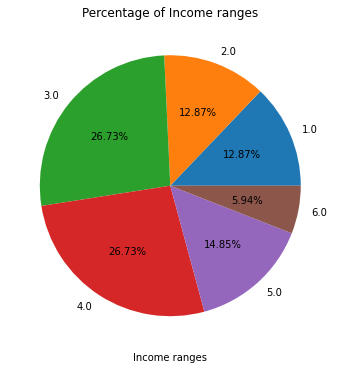

In [63]:
# show income bins and pie plot percentage
print(new_df.groupby('income_range').size(), '\n')
print('Range 1: below $20000')
print('Range 2: between $20001 to $40000')
print('Range 3: between $40001 to $60000')
print('Range 4: between $60001 to $80000')
print('Range 5: between $80001 to $100000')
print('Range 6: above $100001')
feature_plots(new_df, 'income_range', 'Income ranges')

Among income ranges, customer's income between **range 3 and 4 have the highest proportion**.

### Viewed rate and Completed rate ranges

In [64]:
# divide viewed and completed ranges
VR1 = new_df.query("VR_range == 1")
VR2 = new_df.query("VR_range == 2")
VR3 = new_df.query("VR_range == 3")
VR4 = new_df.query("VR_range == 4")
VRs = [VR1, VR2, VR3, VR4]

CR1 = new_df.query("CR_range == 1")
CR2 = new_df.query("CR_range == 2")
CR3 = new_df.query("CR_range == 3")
CR4 = new_df.query("CR_range == 4")
CRs = [CR1, CR2, CR3, CR4]

In [65]:
# create summary df for each ranges
VS1 = summary(VR1, [re, view, comp])
VS2 = summary(VR2, [re, view, comp])
VS3 = summary(VR3, [re, view, comp])
VS4 = summary(VR4, [re, view, comp])
VS_sums = [VS1, VS2, VS3, VS4]

### Subsets inspection

In [66]:
def plot_groupby(df, groupby, ax=None):
    '''
    INPUT:
    
    df - dataframe
    groupby - (str), column name
    ax - None
    
    OUTPUT:
    
    return bar plot by grouping specific column's size
    '''
    return df.groupby(groupby).size().plot.bar(rot=0, ax=ax)

In [67]:
def subs_features_plots(dfs1, dfs2, col, title_1, title_2):
    '''
    INPUT:
    
    dfs - list of dataframes
    col - (str), column name
    
    OUTPUT:
    
    return plots for specific column of dataframes
    '''
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,tight_layout=True, figsize=(12,8))
    plot_groupby(dfs1[0], col, ax=ax1)
    plot_groupby(dfs2[0], col, ax=ax2)
    plot_groupby(dfs1[1], col, ax=ax3)
    plot_groupby(dfs2[1], col, ax=ax4)
    plot_groupby(dfs1[2], col, ax=ax5)
    plot_groupby(dfs2[2], col, ax=ax6)
    plot_groupby(dfs1[3], col, ax=ax7)
    plot_groupby(dfs2[3], col, ax=ax8)
    ax1.set_title(f"{title_1} 0 ~ 0.25")
    ax2.set_title(f"{title_2} 0 ~ 0.25")
    ax3.set_title(f"{title_1} 0.26 ~ 0.5")
    ax4.set_title(f"{title_2} 0.26 ~ 0.5")
    ax5.set_title(f"{title_1} 0.51 ~ 0.75")
    ax6.set_title(f"{title_2} 0.51 ~ 0.75")
    ax7.set_title(f"{title_1} 0.76 ~ 1")
    ax8.set_title(f"{title_2} 0.76 ~ 1")

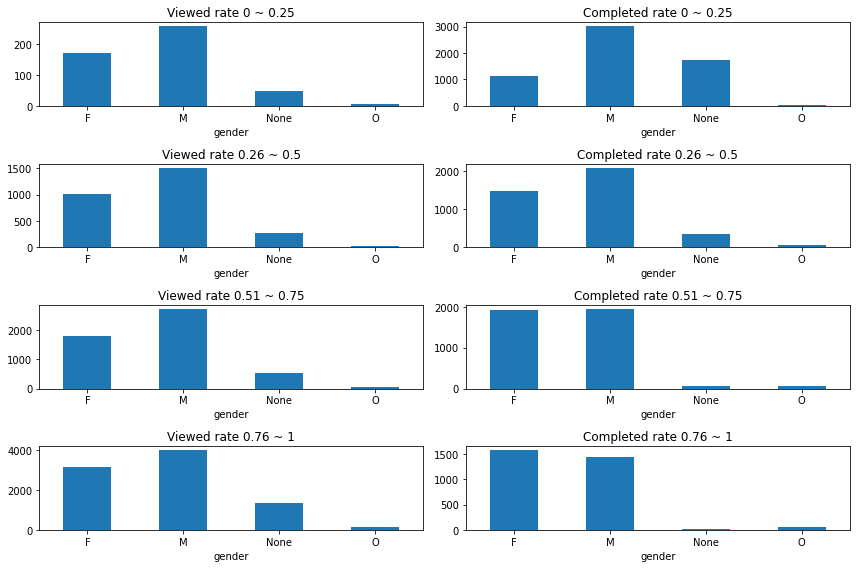

In [68]:
subs_features_plots(VRs, CRs, 'gender', 'Viewed rate', 'Completed rate')

### Percentage of Male in different viewed subsets

`VR1 probability:` 0.028(VR1) x 0.54(gender M) = 1.512%

`VR2 probability:` 0.17(VR2) x 0.54(gender M) = 9.18%

`VR3 probability:` 0.3(VR3) x 0.53(gender M) = 15.9%

`VR4 probability:` 0.51(VR4) x 0.46(gender M) = 23.46%

### Percentage of Gender in different completed subsets

`CR1 probability:` 0.35(CR1) x 0.51(gender M) = 17.85%

`CR2 probability:` 0.23(CR2) x 0.53(gender M) = 12.19%

`CR3 probability:` 0.24(CR3) x 0.49(gender M) = 11.76%; 0.24(CR3) x 0.48(gender F) = 11.52%

`CR4 probability:` 0.18(CR4) x 0.51(gender F) = 9.18%

### Genders

`1.` When viewed and completed rate below 0.5, the portion of **Male** are more than other genders.

`2.` When rate above 0.5 but below 0.76, **Male** still had viewed more than Female, however, **Female** had slightly lower completed rate than Male.

`3.` When completed rate over 0.76, **Female** had more completed than Male.

`Result:` **Male** had more viewed, but **Female** had more completed when viewed rate is higher.

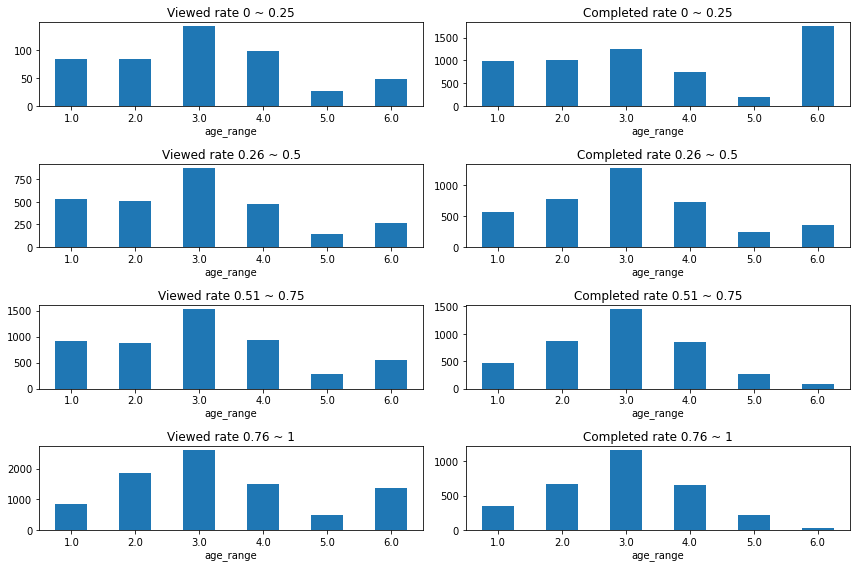

In [69]:
subs_features_plots(VRs, CRs, 'age_range', 'Viewed rate', 'Completed rate')

### Percentage of Age 51 to 65 in different viewed subsets

`VR1 probability:` 0.028(VR1) x 0.29(age 51 to 65) = 0.812%

`VR2 probability:` 0.17(VR2) x 0.31(age 51 to 65) = 5.27%

`VR3 probability:` 0.3(VR3) x 0.3(age 51 to 65) = 9%

`VR4 probability:` 0.51(VR4) x 0.3(age 51 to 65) = 15.3%

### Percentage of Age in different completed subsets

`CR1 probability:` 0.35(CR1) x 0.29(age above 96 yr) = 10.15%

`CR2 probability:` 0.23(CR2) x 0.32(age 51 to 65 yr) = 7.36%

`CR3 probability:` 0.24(CR3) x 0.36(age 51 to 65 yr) = 8.64%

`CR4 probability:` 0.18(CR4) x 0.38(age 51 to 65 yr) = 6.84%

### Ages

`1.` Age between **51 to 65** yr had significant portion than other ages.

`2.` Only age **above 96** yr people had more records when completed rate between 0 to 0.25.

`Result:` Age 51 to 61 yr had higher loyalty.

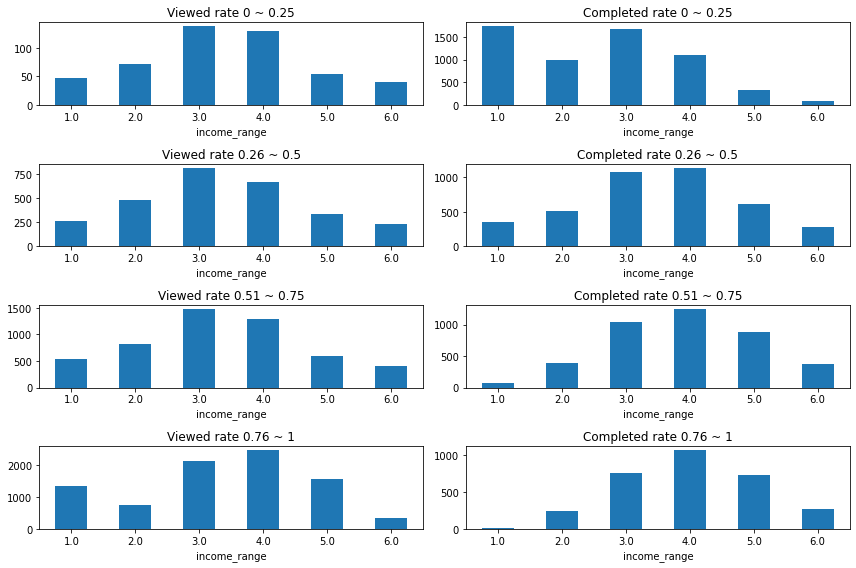

In [70]:
subs_features_plots(VRs, CRs, 'income_range', 'Viewed rate', 'Completed rate')

### Percentage of Income 40k to 80k in different viewed subsets

`VR1 probability:` 0.028(VR1) x 0.29(income 40k to 60k) = 0.812%

`VR2 probability:` 0.17(VR2) x 0.29(income 40k to 60k) = 4.93%

`VR3 probability:` 0.3(VR3) x 0.29(income 40k to 60k) = 8.7%

`VR4 probability:` 0.51(VR4) x 0.29(income 60k to 80k) = 14.79%

### Percentage of Income in different completed subsets

`CR1 probability:` 0.35(CR1) x 0.29(below 20k) = 10.15%

`CR2 probability:` 0.23(CR2) x 0.29(income 60k to 80k) = 6.67%

`CR3 probability:` 0.24(CR3) x 0.31(income 60k to 80k) = 7.44%

`CR4 probability:` 0.18(CR4) x 0.35(income 60k to 80k) = 6.3%

### Incomes

`1.` **Viewed rate below 0.76**, income between **40001 to 60000** had more observations, however, income between 60001 to 80000 are more in highest viewed rate portion.

`2.` **Completed rate below 0.26**, the **lowest income group** had slightly more portion than those who's income between 40001 to 60000. However, abover 0.26, higher income people had higher proportion than other incomes.

`Result:` Higher viewed and completed rate people are more likely those who have income between 60k to 80k.

## Offers inspection - single count

In [71]:
def single_sums_plots(subs, title):
    '''
    INPUT:
    
    subs - subset dataframes
    title - (str), title name for figure
    
    OUTPUT:
    
    return 4 different plots by different subset features
    '''
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,tight_layout=True, figsize=(12,8))
    subs[0].plot.bar(rot=0, ax=ax1)
    subs[1].plot.bar(rot=0, ax=ax2)
    subs[2].plot.bar(rot=0, ax=ax3)
    subs[3].plot.bar(rot=0, ax=ax4)
    ax1.set_title(f'{title} 0 ~ 0.25')
    ax2.set_title(f'{title} 0.26 ~ 0.5')
    ax3.set_title(f'{title} 0.51 ~ 0.75')
    ax4.set_title(f'{title} 0.76 ~ 1.0')
    ax1.set_xlabel('Offer ids')
    ax2.set_xlabel('Offer ids')
    ax3.set_xlabel('Offer ids')
    ax4.set_xlabel('Offer ids')

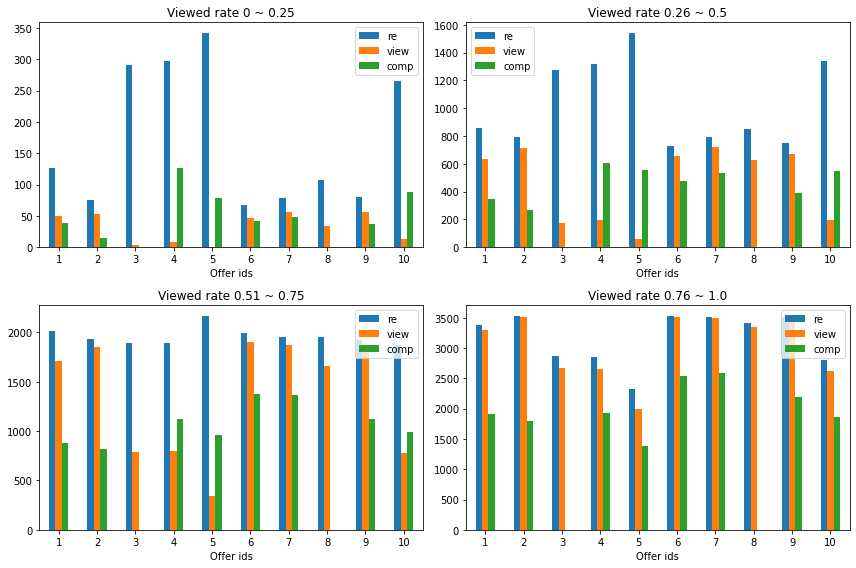

In [72]:
# plots id distribution by different events of different viewed rate
single_sums_plots(VS_sums, 'Viewed rate')

`Lower viewed ratio` When viewed rate below 0.75, **3, 4, 5 and 10** had lower ratio than others.

`Higher viewed ratio` When viewed rate between 0.26 to 0.75, **1, 2, 6, 7, 8 and 9** had higher ratio than others.

`Higher viewed and completed ratio` **6 and 7** had higher ratio.

`Completed without viewed ratio` **4, 5 and 10** had completed id without viewed and the ratio is higher when viewed rate is lower.

`Never completed` **3 and 8** did not have any completed records.

In [73]:
def completed_sum(sub, col, unique=True):
    '''
    INPUT:
    
    sub - subset dataframe
    col - (str), column name
    unique - (bool), use for return unique value counts or multiple value counts
    
    OUTPUT:
    
    id_dic - (dict), unique ids as keys, counts of ids as values
    '''
    id_list = []
    id_dic = {}
    if unique:
        for i in sub[col]:
            ids = np.unique(i).tolist()
            for j in ids:
                id_list.append(j)
    else:
        for i in sub[col]:
            for j in i:
                id_list.append(j)
            
    for i in np.unique(id_list):
        id_dic[i] = id_list.count(i)
        
    return id_dic

In [74]:
def merge_sum(subs, col, unique=True):
    '''
    INPUT:
    
    subs - subset dataframes
    col - (str), column name
    unique - (bool)
    
    OUTPUT:
    
    new_df - unique ids as index, counts of ids as values, different completed rate as column names
    '''
    new_df = pd.DataFrame()
    for i, sub in enumerate(subs):
        sub_dic = completed_sum(sub, col, unique)
        df = pd.DataFrame(index=sub_dic.keys(), data=sub_dic.values(), columns=[f'CR{i+1}'])
        new_df = pd.concat([new_df, df], axis=1)
        
    return new_df

### Examine offer viewed and completed in different CRs

Text(0.5, 0, 'Offer ids')

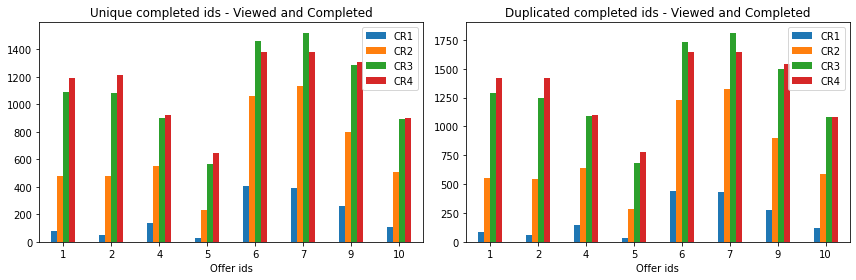

In [75]:
# plot unique or multiple offers which had viewed and completed by different completed rate

fig, (ax1, ax2) = plt.subplots(1, 2,tight_layout=True, figsize=(12,4))
merge_sum(CRs, 'comp_from_viewed').plot.bar(rot=0, ax=ax1)
merge_sum(CRs, 'comp_from_viewed', False).plot.bar(rot=0, ax=ax2)
ax1.set_title('Unique completed ids - Viewed and Completed')
ax2.set_title('Duplicated completed ids - Viewed and Completed')
ax1.set_xlabel('Offer ids')
ax2.set_xlabel('Offer ids')

`Unique vs Multiple ids` It did not have significant difference.

`CR 0 ~ 0.75` **6, 7 and 9** had the higher frequency than others.

`CR 0.76 ~ 1` **Others** had higher counts than other completed rate but not **6 and 7**.

### Examine offers completed without viewed in different CRs

Text(0.5, 0, 'Offer ids')

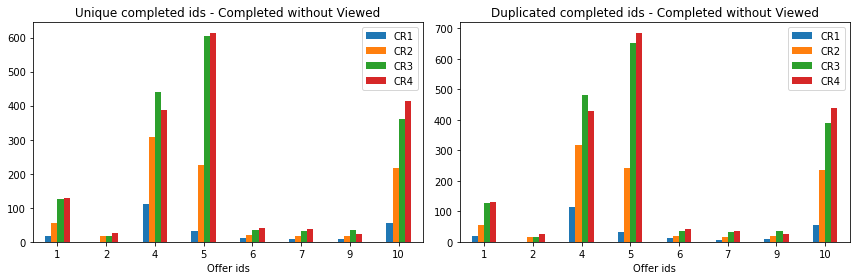

In [76]:
# plot unique or multiple offers which had completed without viewed by different completed rate

fig, (ax1, ax2) = plt.subplots(1, 2,tight_layout=True, figsize=(12,4))
merge_sum(CRs, 'comp_never_viewed').plot.bar(rot=0, ax=ax1)
merge_sum(CRs, 'comp_never_viewed', False).plot.bar(rot=0, ax=ax2)
ax1.set_title('Unique completed ids - Completed without Viewed')
ax2.set_title('Duplicated completed ids - Completed without Viewed')
ax1.set_xlabel('Offer ids')
ax2.set_xlabel('Offer ids')

`Unique vs Multiple ids` It did not have significant difference.

`CR 0 ~0.5` **4** had higher frequency.

`CR 0.51 ~ 1` **5** had higher frequency.

### Examine offer features

In [77]:
def get_id(ids):
    '''
    INPUT:
    
    ids - list of ids
    
    OUTPUT:
    
    offer_ids - offer ids
    '''
    offer_ids = []
    for k, v in id_dic.items():
        if v in ids:
            offer_ids.append(k)
    
    return offer_ids

#### Only viewed ids - 3 and 8

In [78]:
port[port['id'].isin(get_id([3,8]))]

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


The offers never completed are **Informational type** which reward return **0**. 

#### Higher viewed rate ids - 1, 2, 6, 7 and 9

In [79]:
port[port['id'].isin(get_id([1,2,6,7,9]))]

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


There are **60% of BOGO types, 40% are Discount**. 

#### Higher viewed and completed ids - 6, 7 and 9

In [80]:
port[port['id'].isin(get_id([6,7,9]))]

,reward,channels,difficulty,duration,offer_type,id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d


There are **67% are Discount types, only 33% is BOGO**. However, the reward of discount is lower than bogo, but duration is longer. 

#### Higher completed without viewed ids - 4, 5 and 10

In [81]:
port[port['id'].isin(get_id([4,5,10]))]

,reward,channels,difficulty,duration,offer_type,id
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are **67% are Discount, 33% is BOGO**. The minimum duration is 7 days and the maximum difficulty is 20.

### Relation between viewed and completed

In [82]:
# calculate the size of CRs in each VR subsets
size = pd.DataFrame(columns=['Size'], index=['VR1', 'VR2', 'VR3', 'VR4'], data=[x.shape[0] for x in VRs])
size['CR1'] = [x.groupby('CR_range').size().values[0] for x in VRs]
size['CR2'] = [x.groupby('CR_range').size().values[1] for x in VRs]
size['CR3'] = [x.groupby('CR_range').size().values[2] for x in VRs]
size['CR4'] = [x.groupby('CR_range').size().values[3] for x in VRs]
size

,Size,CR1,CR2,CR3,CR4
VR1,482,299,99,61,23
VR2,2808,1354,697,462,295
VR3,5100,1842,1255,1271,732
VR4,8604,2444,1921,2205,2034


In [83]:
def perc_pie_plots(row_idx, explode, title):
    '''
    INPUT:
    
    row_idx - row index of summary df
    explode - list of fraction of radius with which to offset each wedge.
    title - (str), title name
    
    OUTPUT:
    
    return pie plot of VRs and CRs percentage from specific VR subsets
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12))
    ax1.pie(round(size['Size'] / new_df.shape[0], 2), autopct='%.2f%%', labels=size.index, explode=explode, shadow=True)
    ax2.pie(round(size.iloc[row_idx, 1:] / size.iloc[row_idx, 0], 2), autopct='%.2f%%', labels=size.columns[1:])
    ax1.set_title('Percentage of Viewed Subsets')
    ax2.set_title(f'Percentage of CR in {title}')
    ax1.set_xlabel('VRs')
    ax2.set_xlabel('CRs')

### Completed proportion in VR1: 0 ~ 0.25

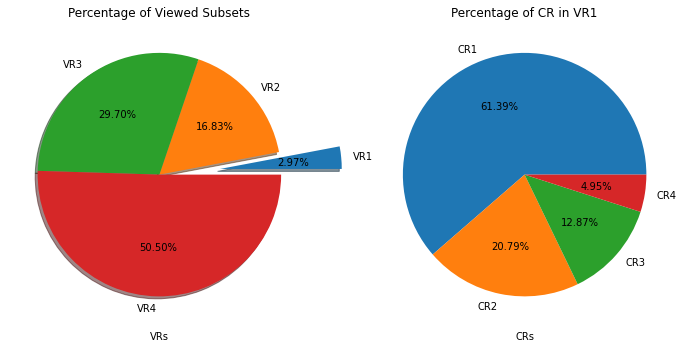

In [84]:
perc_pie_plots(0, [0.5,0,0,0], 'VR1')

<AxesSubplot:title={'center':'Different income and gender in VR1 with CR over 0.5'}, ylabel='gender'>

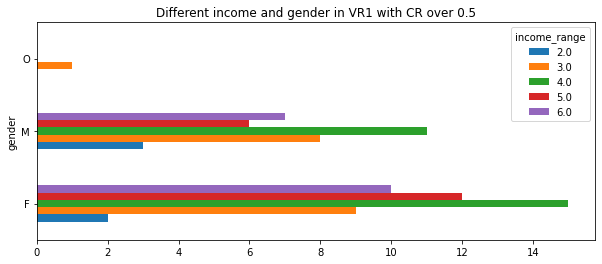

In [96]:
# inspect low viewed higher completed group
new_df.query("VR_range == 1").query("CR > 0.5").groupby(["gender", 'income_range']).size().unstack(fill_value=0).plot.barh(rot=0, figsize=(10, 4), 
                                                                                                                          title='Different income and gender in VR1 with CR over 0.5',
                                                                                                                          ylabel='Counts')

### Viewed rate 0 ~ 0.25

`1.` **Over 80%** of those who had **completed rate below 0.5**, **17% over 0.5**.

`2.` For those CR over 0.5, **Female are more than Male**, and those people have higher income. 

### Completed proportion in VR2: 0.26 ~ 0.5

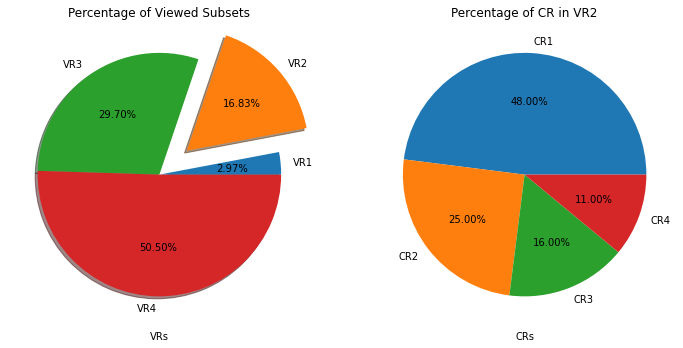

In [87]:
perc_pie_plots(1, [0,0.3,0,0], 'VR2')

<AxesSubplot:title={'center':'Different income and gender in VR2 with CR over 0.5'}, ylabel='gender'>

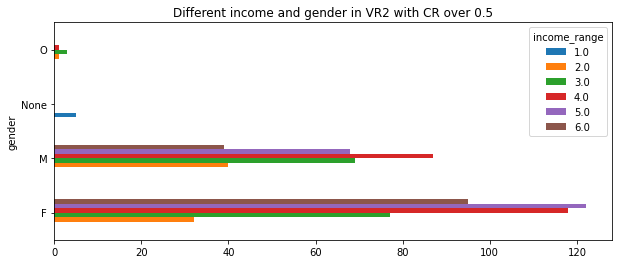

In [97]:
# inspect low viewed higher completed group
new_df.query("VR_range == 2").query("CR > 0.5").groupby(["gender", 'income_range']).size().unstack(fill_value=0).plot.barh(rot=0, figsize=(10, 4), 
                                                                                                                          title='Different income and gender in VR2 with CR over 0.5',
                                                                                                                          ylabel='Counts')

### Viewed rate 0.26 ~ 0.5

`1.` **Over 70%** of those who had **completed rate below 0.5, 27% over 0.5**.

`2.` For those CR over 0.5, **Female** are more than Male, and those people have higher income.

### Completed proportion in VR3: 0.51 ~ 0.75

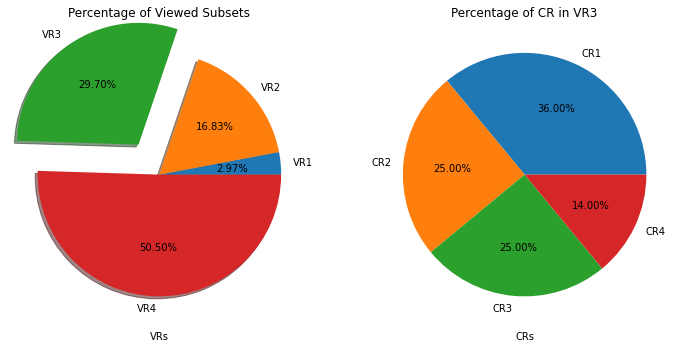

In [88]:
perc_pie_plots(2, [0,0,0.3,0], 'VR3')

<AxesSubplot:title={'center':'Different income and gender in VR3 with CR below 0.5'}, ylabel='gender'>

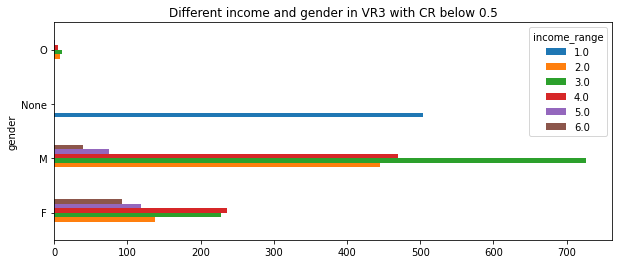

In [98]:
# inspect high viewed lower completed group
new_df.query("VR_range == 3").query("CR < 0.51").groupby(["gender", 'income_range']).size().unstack(fill_value=0).plot.barh(rot=0, figsize=(10, 4), 
                                                                                                                          title='Different income and gender in VR3 with CR below 0.5',
                                                                                                                          ylabel='Counts')

### Viewed rate 0.51 ~ 0.75

`1.` **Over 60%** of those who had **completed rate below 0.5**.

`2.` Among the 60%, **57% are Male, 26% are Female, 16% are None gender**.

`3.` Comparing with low VR and high CR's people, higher income people are less. 

### Completed proportion in VR4: 0.76 ~ 1

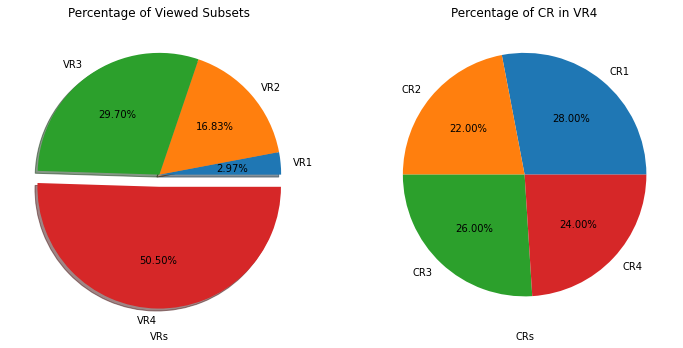

In [89]:
perc_pie_plots(3, [0,0,0,0.1], 'VR4')

<AxesSubplot:title={'center':'Different income and gender in VR4 with CR below 0.5'}, ylabel='gender'>

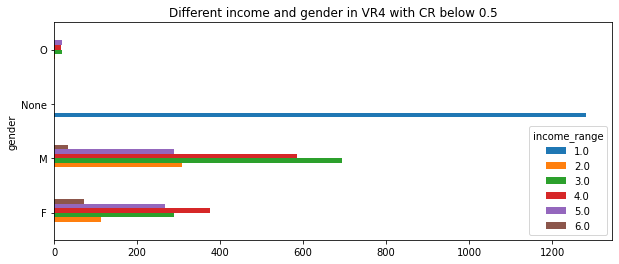

In [100]:
# inspect high viewed lower completed group
new_df.query("VR_range == 4").query("CR < 0.51").groupby(["gender", 'income_range']).size().unstack(fill_value=0).plot.barh(rot=0, figsize=(10, 4), 
                                                                                                                          title='Different income and gender in VR4 with CR below 0.5',
                                                                                                                          ylabel='Counts')

### Viewed rate 0.76 ~ 1

`1.` Around **50%** of those who had **completed rate below 0.5**.

`2.` Among the 50%, **44% are Male, 26% are Female, 29% are None gender**.

`3.` Comparing with VR between 0.51 to 0.75 and CR below 0.5 people, the potion of None gender people are more than Female.

<a class="anchor" id="5"></a>
# Part IV: Conclusion

## 1. Customer features between genders, ages and incomes

### Male

`1.` 50% from all observations.

`2.` 95% are below age 80 yr.

`3.` 96% of them have income which distribute between 20001 to 100000.

### Female

`1.` 36% from all observations.

`2.` 80% are between 36 to 80 yr, 9% are over 81 yr.

`3.` 79% of them have income which distribute between 40001 to 100000.

### None gender

`1.` 13% from all observations.

`2.` 100% of them age over 96 yr.

`3.` 100% of them have the income below 20000.

### Other genders

`1.` 1.2% from all observations.

`2.` 94% are below 80 yr.

`3.` 100% of them have income between 20001 to 100000.

## 2. Relation between ages and income in VRs and CRs

`1.` As above, in the CR subsets, **elders had more the lowest completed records**, which might due to the people who's age above 96 yr and 97% of them have income below 20000. It makes sense that **if customer is retired, and their income became 0, they might still have interest to view but hesitate to complete**.

`2.` The percentage of **people who's age between 51 to 65 yr is 30% and 80% of them have the income distribution between 40001 to 100000**, therefore, for age 51 to 65 yr customers, the reason for them have higher viewed and higher completed due to they have **stable finance condition**. 

## 3. Summary of clients:

`1.` **Male apparently had higher viewed** proportion than Female.

`2.` When **completed rate is over 0.5**, **Female had completed more** than Male.

`3.` The age distribution of **Male is younger** than Female, however, the income distribution of **Female have higher income**.

`4.` For those completed without viewed offers, Female had more portion than Male, also the income distribution is at least 40000.

## 4. Relation between offers

`Never completed:` **Informational type only**.

`Higher viewed:` **Bogo and Discount types**, 60% of Bogo, 40% of Discount, the average of reward, difficulty and duration is **6, 8.4 and 6.8**.

`Higher viewed and completed:` 67% is **Discount** type, 33% is **Bogo** type, the average of reward, difficulty and duration is **3.3, 7.3 and 7.3**.

`Higher completed without viewed:` 67% is **Discount** type, 33% is **Bogo** type, the average of reward, difficulty and duration is **4, 11.7 and 8**.

## 5. The offer preference of clients:

`1.` For clients who had higher viewed rate, prefer **BUY ONE GET ONE FREE** offers more than Discount one.

`2.` The offers which had been higher viewed also has **higher reward average**.

`3.` The same feature of offers which had been completed are more **Discount** type, the difference is offers which had been viewed were **lower reward, less difficulty and shorter duration**. Comparing those had not been viewed, **reward is 1.2 times higher, 1.6 times higher of difficulty and 1.1 times longer of duration**.